In [1]:
import copy
import itertools
import numpy as np
import glob
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
from py2tex import py2tex

In [5]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [6]:
import trove
import trove.config_parser

# Load Data

In [7]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
cp = trove.config_parser.ConfigParser( config_fp )
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
)

In [8]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [9]:
h_param = .702

# Extract Quantities

## Halo Quantities

In [10]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
vc = verdict.Dict({})
rstar = verdict.Dict({})
rvir = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    # Load from summary data if available
    all_data_types_in_summary_data = True
    for data_type in [ 'Mvir', 'Mstar', 'Vc', 'Rstar0.5', 'Rvir' ]:
        if data_type not in data:
            data[data_type] = {}
        all_data_types_in_summary_data = all_data_types_in_summary_data & ( key in data[data_type] )
    if all_data_types_in_summary_data:
        mvir[key] = data['Mvir'][key]
        mstar[key] = data['Mstar'][key]
        vc[key] = data['Vc'][key]
        rstar[key] = data['Rstar0.5'][key]
        rvir[key] = data['Rvir'][key]
        continue
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600,] )[0] / h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600,] )[0] / h_param
    vc[key] = h_data.get_mt_data( 'Vmax', snums=[600,] )[0]
    rstar[key] = h_data.get_mt_data( 'Rstar0.5', snums=[600,] )[0] / h_param
    rvir[key] = h_data.get_mt_data( 'Rvir', snums=[600,] )[0] / h_param
    
    data['Mvir'][key] = mvir[key]
    data['Mstar'][key] = mstar[key]
    data['Vc'][key] = vc[key]
    data['Rstar0.5'][key] = rstar[key]
    data['Rvir'][key] = rvir[key]
    
data.to_hdf5( data_filepath )

100%|██████████| 16/16 [00:00<00:00, 94920.60it/s]


## tcool / tff

In [11]:
# tcool/tff
missing = []
tcool_tff = verdict.Dict({})
for key in cp.variations:
    
    try:
        # Get the file
        res = cp.get( key, 'subpath' ).split( '_' )[-1][3:]
        fp = os.path.join( pm['processed_data_dir'], 'tcool_tff', 't_cool_to_t_ff_{}_{}.npz'.format( key, res ) )
        tcool_tff_file = np.load( fp )
    except FileNotFoundError:
        missing.append( key )
        
        continue
        
    tcool_tff[key] = 10.**tcool_tff_file['log_t_cool_to_t_ff_smooth'][0]

## Vrot / sigma

In [12]:
# tcool/tff
missing = []
vrot_sigma = verdict.Dict({})
for key in cp.variations:
    
    try:
        # Get the file
        res = cp.get( key, 'subpath' ).split( '_' )[-1][3:]
        fp = os.path.join( pm['processed_data_dir'], 'Vrot_to_sigma', 'Vrot_to_sigma_{}_{}.npz'.format( key, res ) )
        vrot_sigma_file = np.load( fp )
    except FileNotFoundError:
        missing.append( key )
        
        continue
        
    vrot_sigma[key] = vrot_sigma_file['Vrot_to_sigmas'][0]

## Disk Fractions

In [13]:
# Width change
sigma_cosphi = data['cosphi']['84th_percentile'] - data['cosphi']['16th_percentile']
delta_sigma_cosphi = sigma_cosphi.inner_item( -1 ) - sigma_cosphi.inner_item( 0 )
negative_delta_sigma_cosphi = -1. * delta_sigma_cosphi
sigma_cosphi_ratio = sigma_cosphi.inner_item( 0 ) / sigma_cosphi.inner_item( -1 )
std_cosphi_ratio = data['cosphi']['std'].inner_item( 0 ) / data['cosphi']['std'].inner_item( -1 )

In [14]:
# PDF value changes
delta_pdf = data['cosphi']['pdf(cos theta=0)'].inner_item( -1 ) - data['cosphi']['pdf(cos theta=0)'].inner_item( 0 )
ratio_pdf = data['cosphi']['pdf(cos theta=0)'].inner_item( -1 ) / data['cosphi']['pdf(cos theta=0)'].inner_item( 0 )

In [15]:
# Spherical harmonics
delta_q20 = data['cosphi']['q20'].inner_item( -1 ) - data['cosphi']['q20'].inner_item( 0 )
delta_q33 = data['cosphi']['q33'].inner_item( -1 ) - data['cosphi']['q33'].inner_item( 0 )

In [16]:
# Disk fraction
disk_frac = verdict.Dict({})
smooth_disk_frac = verdict.Dict({})
for key in cp.variations:
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        in_disk = np.abs( data['cosphi']['points'][key] ) < pm['disk_costheta']
        disk_fracs.append( pdf[in_disk].sum()/pdf.sum() )
    disk_frac[key] = disk_fracs
    
    smooth_disk_frac[key] = scipy.signal.savgol_filter(
        disk_fracs,
        window_length = 9,
        polyorder = 1,
    )

In [17]:
# Change in disk fraction
t_t1e5_inds = np.arange( data['cosphi']['t_t1e5_centers'][key].size )
before_ind = t_t1e5_inds[np.isclose( data['cosphi']['t_t1e5_centers'][key], -pm['aligned_fraction_half_dt']/1e3 )][0]
after_ind = t_t1e5_inds[np.isclose( data['cosphi']['t_t1e5_centers'][key], pm['aligned_fraction_half_dt']/1e3 )][0]
delta_disk_frac = disk_frac.inner_item( after_ind ) - disk_frac.inner_item( before_ind )
delta_smooth_disk_frac = smooth_disk_frac.inner_item( after_ind ) - smooth_disk_frac.inner_item( before_ind )

In [18]:
# Angular Momentum Disk fraction
jdisk_frac = verdict.Dict({})
smooth_jdisk_frac = verdict.Dict({})
for key in cp.variations:
    jdisk_fracs = []
    for i, pdf in enumerate( data['jzjmag']['pdf'][key] ):
        
        in_disk = data['jzjmag']['points'][key] > pm['disk_jzjmag']
        jdisk_fracs.append( pdf[in_disk].sum()/pdf.sum() )
    jdisk_frac[key] = jdisk_fracs
    
    smooth_jdisk_frac[key] = scipy.signal.savgol_filter(
        jdisk_fracs,
        window_length = 9,
        polyorder = 1,
    )
delta_jdisk_frac = jdisk_frac.inner_item( after_ind ) - jdisk_frac.inner_item( before_ind )
delta_smooth_jdisk_frac = smooth_jdisk_frac.inner_item( after_ind ) - smooth_jdisk_frac.inner_item( before_ind )

In [19]:
# Minimum Disk Fraction
min_delta_disk_frac = verdict.Dict({})
for key, item in delta_disk_frac.items():
    min_delta_disk_frac[key] = min( item, delta_jdisk_frac[key] )

In [20]:
# Disk fraction (aligned fraction) for thin disk stars, for use as a reference point
aligned_frac = verdict.Dict({})
aligned_frac_recent = verdict.Dict({})
thin_disk_aligned_missing = []
for key in cp.variations:
    aligned = np.abs( data['cosphi_stars']['centers'] ) < pm['disk_costheta']
    
    try:
        pdf = data['cosphi_stars']['thin_disk'][key]
        aligned_frac[key] = pdf[aligned].sum()/pdf.sum()

        pdf = data['cosphi_stars']['thin_disk_recent'][key]
        aligned_frac_recent[key] = pdf[aligned].sum()/pdf.sum()
    except KeyError:
        thin_disk_aligned_missing.append( key )

In [21]:
# Disk fraction as the fraction under the PDF for recent thin disk stars

# Calculate average pdf
avg_cosphi_stars = (
    ( data['cosphi_stars']['thin_disk_recent'] * data['thin_disk_fraction_recent'] ).array().sum( axis=0 ) / 
    data['thin_disk_fraction_recent'].array().sum()
)
# Enforce normalization
avg_cosphi_stars /= avg_cosphi_stars.sum() * ( data['cosphi_stars']['centers'][1] - data['cosphi_stars']['centers'][0] ) 

disk_frac_pdf = verdict.Dict({})
for key in cp.variations:
    
    # Interpolated to deal with different binning
    avg_cosphi_stars_key = scipy.interpolate.interp1d( data['cosphi_stars']['centers'], avg_cosphi_stars )( data['cosphi']['points'][key] )
    
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        # The line underneath
        min_of_both = np.min( [ pdf, avg_cosphi_stars_key], axis=0 )
        
        # The fraction. Equivalent to summing the area
        # (alt code: min_of_both.sum() * data['cosphi']['points'][key][1] - data['cosphi']['points'][key][0] )
        frac = min_of_both.sum() / avg_cosphi_stars_key.sum()

        disk_fracs.append( frac )
        
    disk_frac_pdf[key] = disk_fracs
delta_disk_frac_pdf = disk_frac_pdf.inner_item( -1 ) - disk_frac_pdf.inner_item( 0 )

# Ideal case for scaling
min_of_both_flat = np.min( [ np.full( avg_cosphi_stars.shape,  0.5 ), avg_cosphi_stars], axis=0 )
disk_frac_flat = min_of_both_flat.sum() / avg_cosphi_stars.sum()
delta_disk_frac_ideal = 1. - disk_frac_flat

delta_disk_frac_pdf /= delta_disk_frac_ideal

In [22]:
# Disk fraction as the fraction under the PDF for all thin disk stars

# Calculate average pdf
avg_cosphi_stars = (
    ( data['cosphi_stars']['thin_disk'] * data['thin_disk_fraction'] ).array().sum( axis=0 ) / 
    data['thin_disk_fraction'].array().sum()
)
# Enforce normalization
avg_cosphi_stars /= avg_cosphi_stars.sum() * ( data['cosphi_stars']['centers'][1] - data['cosphi_stars']['centers'][0] ) 

disk_frac_pdf_all = verdict.Dict({})
for key in cp.variations:
    
    # Interpolated to deal with different binning
    avg_cosphi_stars_key = scipy.interpolate.interp1d( data['cosphi_stars']['centers'], avg_cosphi_stars )( data['cosphi']['points'][key] )
    
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        # The line underneath
        min_of_both = np.min( [ pdf, avg_cosphi_stars_key], axis=0 )
        
        # The fraction. Equivalent to summing the area
        # (alt code: min_of_both.sum() * data['cosphi']['points'][key][1] - data['cosphi']['points'][key][0] )
        frac = min_of_both.sum() / avg_cosphi_stars_key.sum()

        disk_fracs.append( frac )
        
    disk_frac_pdf_all[key] = disk_fracs
delta_disk_frac_pdf_all = disk_frac_pdf_all.inner_item( -1 ) - disk_frac_pdf_all.inner_item( 0 )

# Ideal case for scaling
min_of_both_flat = np.min( [ np.full( avg_cosphi_stars.shape,  0.5 ), avg_cosphi_stars], axis=0 )
disk_frac_flat = min_of_both_flat.sum() / avg_cosphi_stars.sum()
delta_disk_frac_ideal_all = 1. - disk_frac_flat

delta_disk_frac_pdf_all /= delta_disk_frac_ideal_all

In [23]:
# Disk fraction as the fraction under the PDF for all disk stars

# Calculate average pdf
# avg_cosphi_stars = (
#     ( data['cosphi_stars']['thin_disk'] * data['thin_disk_fraction'] ).array().sum( axis=0 ) / 
#     data['thin_disk_fraction'].array().sum()
# )
# # Enforce normalization
# avg_cosphi_stars /= avg_cosphi_stars.sum() * ( data['cosphi_stars']['centers'][1] - data['cosphi_stars']['centers'][0] ) 
avg_cosphi_stars = data['cosphi_stars']['disk']['m12i_md']

disk_frac_pdf_disk = verdict.Dict({})
for key in cp.variations:
    
    # Interpolated to deal with different binning
    avg_cosphi_stars_key = scipy.interpolate.interp1d( data['cosphi_stars']['centers'], avg_cosphi_stars )( data['cosphi']['points'][key] )
    
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        # The line underneath
        min_of_both = np.min( [ pdf, avg_cosphi_stars_key], axis=0 )
        
        # The fraction. Equivalent to summing the area
        # (alt code: min_of_both.sum() * data['cosphi']['points'][key][1] - data['cosphi']['points'][key][0] )
        frac = min_of_both.sum() / avg_cosphi_stars_key.sum()

        disk_fracs.append( frac )
        
    disk_frac_pdf_disk[key] = disk_fracs
delta_disk_frac_pdf_disk = disk_frac_pdf_disk.inner_item( -1 ) - disk_frac_pdf_disk.inner_item( 0 )

# Ideal case for scaling
min_of_both_flat = np.min( [ np.full( avg_cosphi_stars.shape,  0.5 ), avg_cosphi_stars], axis=0 )
disk_frac_flat = min_of_both_flat.sum() / avg_cosphi_stars.sum()
delta_disk_frac_ideal_all = 1. - disk_frac_flat

delta_disk_frac_pdf_disk /= delta_disk_frac_ideal_all

In [24]:
# Median change
med_cosphi = verdict.Dict({})
abs_med_cosphi = verdict.Dict({})
for key in cp.variations:
    medians = []
    abs_medians = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):

        cdf = np.cumsum( pdf )
        cdf /= cdf[-1]
        medians.append( scipy.interpolate.interp1d( cdf, data['cosphi']['points'][key] )( 0.5 ) )
        
        is_above = data['cosphi']['points'][key] > 0.
        as_above = pdf[is_above]
        so_below = pdf[data['cosphi']['points'][key] < 0.][::-1]
        as_above += so_below
        cdf_abs = np.cumsum( as_above )
        cdf_abs /= cdf_abs[-1]
        abs_medians.append( scipy.interpolate.interp1d( cdf_abs, data['cosphi']['points'][key][is_above] )( 0.5 ) )
        
    med_cosphi[key] = np.array( medians )
    abs_med_cosphi[key] = np.array( abs_medians )

In [25]:
# Delta of median
delta_med_cosphi = med_cosphi.inner_item( 0 ) - med_cosphi.inner_item( -1 )
delta_abs_med_cosphi = abs_med_cosphi.inner_item( 0 ) - abs_med_cosphi.inner_item( -1 )

In [26]:
# Fraction above 40 kpc
r = 40.
cdfs = data['R1e5K']['pdf'].cumsum()
cdfs /= cdfs.inner_item( -1 )
f_above_r = verdict.Dict({})
for key, cdf in cdfs.items():
    f_above_r[key] = 1. - scipy.interpolate.interp1d( data['R1e5K']['points'][key], cdf )( r )

In [27]:
values = {
    'median_R1e5K': data['R1e5K']['median'],
    'median_R1e5K_rgal': data['R1e5K_rgal']['median'],
    'thin_disk_frac': data['thin_disk_fraction'],
    'thin_disk_frac_recent': data['thin_disk_fraction_recent'],
    'thin_disk_frac_sloanr': data['thin_disk_fraction_sloanr'],
    'mvir': mvir,
    'mstar': mstar,
    'rstar': rstar,
    'tcool_tff': tcool_tff,
    'negative_delta_sigma_cosphi': negative_delta_sigma_cosphi,
    'sigma_cosphi_ratio': sigma_cosphi_ratio,
    'std_cosphi_ratio': std_cosphi_ratio,
    'delta_pdfcosphi': delta_pdf,
    'ratio_pdfcosphi': ratio_pdf,
    'disk_frac': disk_frac,
    'delta_disk_frac': delta_disk_frac,
    'jdisk_frac': jdisk_frac,
    'delta_jdisk_frac': delta_jdisk_frac,
    'smooth_disk_frac': smooth_disk_frac,
    'delta_smooth_disk_frac': delta_smooth_disk_frac,
    'smooth_jdisk_frac': smooth_jdisk_frac,
    'delta_smooth_jdisk_frac': delta_smooth_jdisk_frac,
    'min_delta_disk_frac': min_delta_disk_frac,
    'disk_frac_pdf': disk_frac_pdf,
    'delta_disk_frac_pdf': delta_disk_frac_pdf,
    'disk_frac_pdf_all': disk_frac_pdf_all,
    'delta_disk_frac_pdf_all': delta_disk_frac_pdf_all,
    'disk_frac_pdf_disk': disk_frac_pdf_disk,
    'delta_disk_frac_pdf_disk': delta_disk_frac_pdf_disk,
    'delta_q20': delta_q20,
    'delta_q33': delta_q33,
    'delta_med_cosphi': delta_med_cosphi,
    'delta_abs_med_cosphi': delta_abs_med_cosphi,
    'f_above_r': f_above_r,
}

# Plot

## Settings

In [28]:
labels = {
    'delta_thin_disk': r'$\Delta f_{\rm thin}$',
    'median_R1e5K': r'median $R_{T=10^5\, {\rm K}}$ (kpc)',
    'median_R1e5K_rgal': r'median $R_{T=10^5\, {\rm K}}$ / $R_{\rm gal}$',
    'thin_disk_frac': r'stellar thin disk fraction',
#     'thin_disk_frac_recent': r'$f_{\rm thin\,disk}$($z=0$, age $<1$ Gyr)',
    'thin_disk_frac_recent': r'$f_{\rm thin\,disk,\,recent}$',
    'thin_disk_frac_tracked': r'$f_{\rm thin}(\star,z=0,$ tracked)',
    'thin_disk_frac_sloanr': r'$f_{\rm thin\,disk}$($z=0$, Sloan r band)',
    'mvir': r'$M_{\rm vir}$ $[M_\odot]$',
    'mstar': r'$M_{\star}$ $[M_\odot]$',
    'rstar': r'$R_{\star, 0.5}$ [kpc]',
    'tcool_tff': r'$t_{\rm cool}^{(s)}$ / $t_{\rm ff}$ at $0.1 R_{\rm vir}$', 
    'sigma_cosphi': r'$\sigma( \cos\theta )$',
    'negative_delta_sigma_cosphi': r'$\sigma_{\cos\theta,\,{\rm hot}}$ - $\sigma_{\cos\theta,\,{\rm cool}}$',
    'sigma_cosphi_ratio': r'$\sigma_{\cos\theta,\,{\rm hot}}$ / $\sigma_{\cos\theta,\,{\rm cool}}$',
    'std_cosphi_ratio': r'${\rm STD}_{\cos\theta,\,{\rm hot}}$ / ${\rm STD}_{\cos\theta,\,{\rm cool}}$',
    'delta_pdfcosphi': r'$( dM_{\rm after\,cooling} - dM_{\rm before\,cooling} )\mid_{\rm galaxy\,plane}$',
    'ratio_pdfcosphi': r'${\rm PDF}(\cos\theta=0)_{\rm cool}$ / ${\rm PDF}(\cos\theta=0)_{\rm hot}$',
    'pdfcosphi_0': r'${\rm PDF}(\cos\theta=0)$',
#     'disk_frac': r'$M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
#     'delta_disk_frac': r'$\Delta M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
#     'disk_frac': 'aligned mass fraction ($\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')$',
#     'delta_disk_frac': 'change in aligned mass fraction',
    'disk_frac': r'aligned accretion, $f_{\rm aligned}$',
    'delta_disk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned}$',
    'jdisk_frac': r'aligned accretion, $f_{\rm aligned,\,j}$',
    'delta_jdisk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned,\,j}$',
    'smooth_disk_frac': r'aligned accretion, $f_{\rm aligned}$',
    'delta_smooth_disk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned}$',
    'smooth_jdisk_frac': r'aligned accretion, $f_{\rm aligned,\,j}$',
    'delta_smooth_jdisk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned,\,j}$',
    'min_delta_disk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned,\,min}$',
    'disk_frac_pdf': r'aligned accretion under curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf': r'$\Delta$(aligned accretion under curve), $\Delta f_{\rm aligned}$',
    'disk_frac_pdf_all': r'aligned accretion under all curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf_all': r'$\Delta$(aligned accretion under all curve), $\Delta f_{\rm aligned}$',
    'disk_frac_pdf_disk': r'aligned accretion under disk curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf_disk': r'$\Delta$(aligned accretion under disk curve), $\Delta f_{\rm aligned}$',
    'delta_q20': r'$\Delta q_{20}$',
    'delta_q33': r'$\Delta q_{33}$',
    'med_cosphi': r'$\cos\theta_{50}$',
    'delta_med_cosphi': r'$\Delta \cos\theta_{50}$',
    'abs_med_cosphi': r'$\mid \cos\theta_{50}\mid$',
    'delta_abs_med_cosphi': r'$\mid \Delta \cos\theta_{50}\mid$',
    'quiet_frac': r'CCF fraction, no R cut',
    'quiet_frac_strict': r'CCF fraction',
}

In [29]:
logscale = [ 'mvir', 'mstar', 'tcool_tff' ]

In [30]:
fractions = [
    'thin_disk_frac',
    'thin_disk_frac_recent',
    'thin_disk_frac_tracked',
    'thin_disk_frac_sloanr',
    'quiet_frac',
    'quiet_frac_strict',
]

In [31]:
arrowprops = {
    'arrowstyle': '-',
}

In [32]:
custom_annot_args = {
    ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ): {
        'm12f_md': {
            'ha': 'right',
            'va': 'bottom',
            'xytext': ( -3, 3 ),
        },
        'm12i_cr': {
            'ha': 'right',
            'va': 'center',
            'xytext': ( -8, 0 ),
        },
        'm12i_md': {
            'ha': 'center',
            'va': 'bottom',
            'xytext': ( 3, 5 ),
        },
        'm12i': {
            'ha': 'left',
            'va': 'top',
            'xytext': ( 3, -3 ),
        },
#         'm11e_md': {
#             'xytext': ( 50, 3 ),
#             'arrowprops': arrowprops,
#         },
#         'm11c': {
#             'xytext': ( 50, 3 ),
#             'arrowprops': arrowprops,
#         },
#         'm11q_md': {
#             'xytext': ( 85, 0 ),
#             'arrowprops': arrowprops,
#             'ha': 'left',
#             'va': 'bottom',
#         },
#         'm11a': {
#             'xytext': ( 0, 65 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
#         'm11i_md': {
#             'xytext': ( 0, 40 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
#         'm11d_md': {
#             'xytext': ( 20, 25 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
        'm11a': None,
        'm11c': None,
        'm11d_md': None,
        'm11e_md': None,
        'm11i_md': None,
        'm11q_md': None,
    },
    ( 'thin_disk_frac_recent', 'delta_disk_frac' ): {
        'm12i': {
            'ha': 'right',
            'va': 'bottom',
            'xytext': ( -3, 3 ),
        },
        'm11a': None,
        'm11c': None,
        'm11d_md': None,
        'm11e_md': None,
        'm11i_md': None,
        'm11q_md': None,
    },
}

In [33]:
markers = {
    'md': 'o',
    'cr': '^',
#     'mhdcv': 'P',
    '': 's',
}

In [34]:
marker_labels = {
    'md': 'hydro+',
    'cr': 'CR+',
#     'mhdcv': 'MHD+',
    '': 'no metal diffusion',
}

In [35]:
custom_lims = {
    'median_R1e5K_rgal': [ 0, 4 ],
    'mvir': [ 3e10, 2e12 ],
    'mstar': [ 7e7, 2e11 ],
    'tcool_tff': [ 0.08, 20 ],
    'delta_smooth_disk_frac': [ -0.04, 0.36 ],
}

In [36]:
def get_lim( vs, is_log, v_key, scale_upper=1., scale_lower=1. ):
    
    if v_key in custom_lims:
        return custom_lims[v_key]
    
    if v_key in fractions:
        return [ 0, 1 ]
    
    min_v = np.nanmin( vs.array() )
    if not is_log:
        min_v = min( 0, min_v )
        
    max_v = np.nanmax( vs.array() ) * scale_upper
    min_v *= scale_lower
                      
    return min_v, max_v

## One Value per Axis

In [37]:
# Automatic
value_keys = list( values.keys() )
combinations = itertools.combinations( value_keys, 3 )

In [38]:
# Manual
combinations = [
    ( 'delta_pdfcosphi', 'thin_disk_frac_recent', 'mvir' ),
    ( 'thin_disk_frac_recent', 'delta_pdfcosphi', 'mvir' ),
    ( 'delta_disk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_jdisk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'min_delta_disk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_disk_frac', 'delta_jdisk_frac', 'mvir' ),
    ( 'delta_smooth_disk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_smooth_jdisk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_smooth_disk_frac', 'delta_smooth_jdisk_frac', 'mvir' ),
    ( 'thin_disk_frac_recent', 'delta_disk_frac', 'mvir' ),
    ( 'mvir', 'rstar', 'thin_disk_frac_recent' ),
    ( 'thin_disk_frac_recent', 'thin_disk_frac_sloanr', 'delta_disk_frac' ),
    ( 'thin_disk_frac_recent', 'thin_disk_frac_sloanr', 'mvir' ),
    ( 'delta_disk_frac_pdf', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_disk_frac_pdf_all', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_disk_frac', 'delta_disk_frac_pdf', 'mvir' ),
    ( 'delta_disk_frac', 'delta_disk_frac_pdf_all', 'mvir' ),
    ( 'delta_disk_frac', 'delta_disk_frac_pdf_disk', 'mvir' ),
    ( 'thin_disk_frac_recent', 'delta_disk_frac_pdf_disk', 'mvir' ),
]

In [39]:
combinations_to_save = [
    ( 'thin_disk_frac_recent', 'thin_disk_frac_sloanr', 'mvir' ),
]
combinations_no_annotate = combinations_to_save

In [40]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/thin_disk_v_thin_disk.pdf


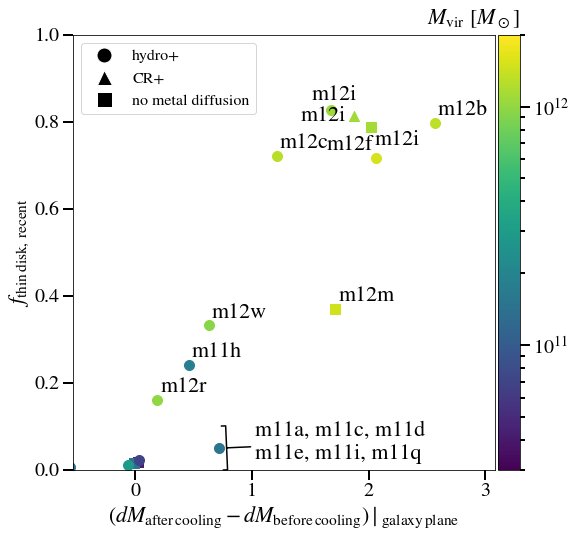

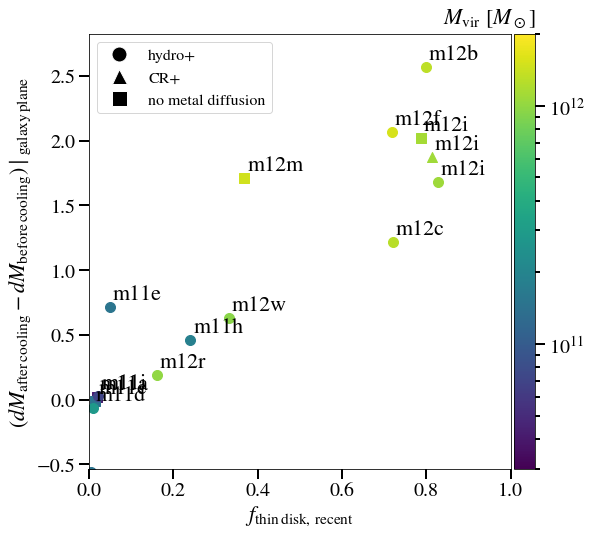

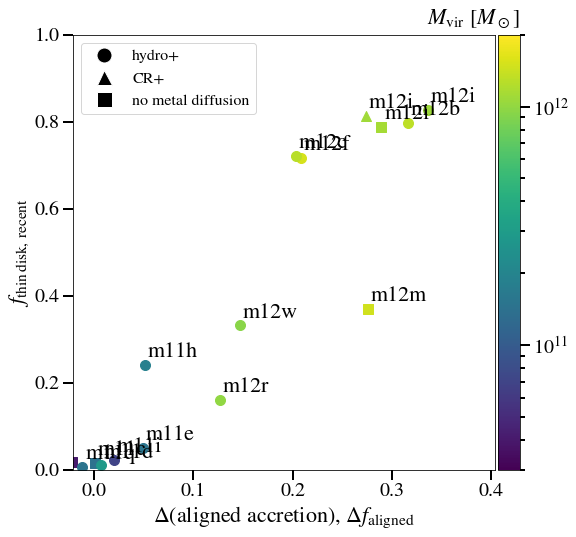

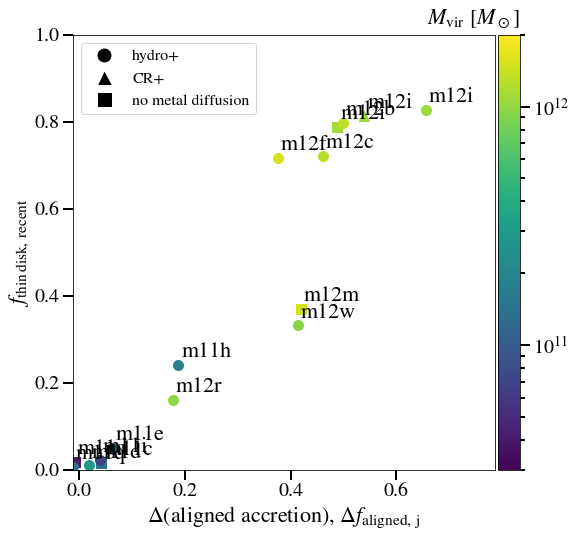

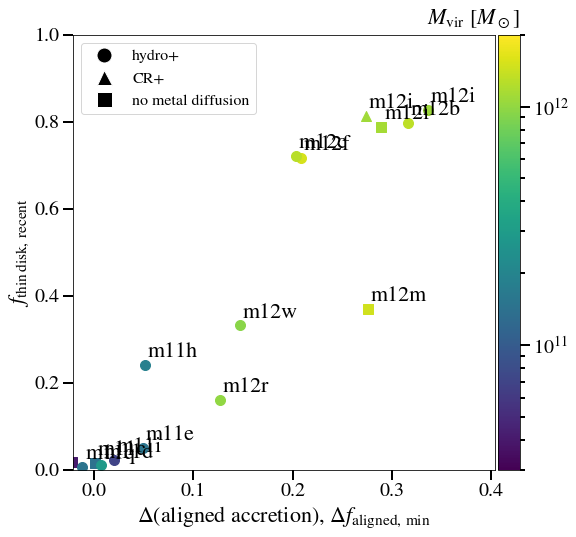

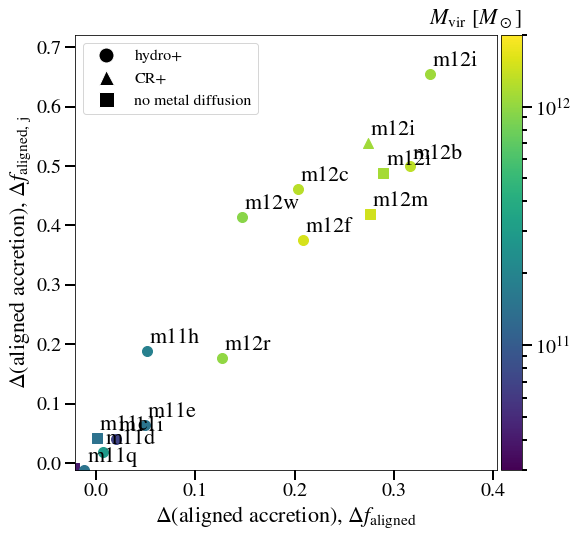

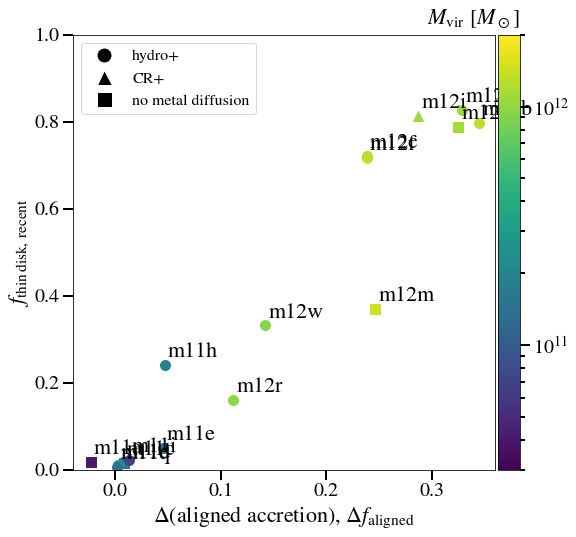

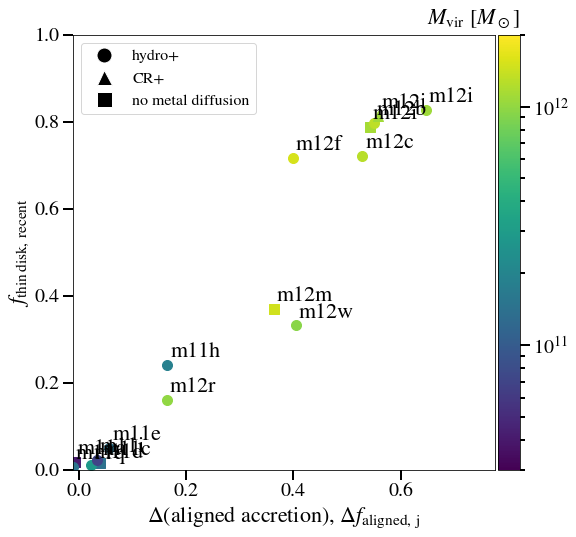

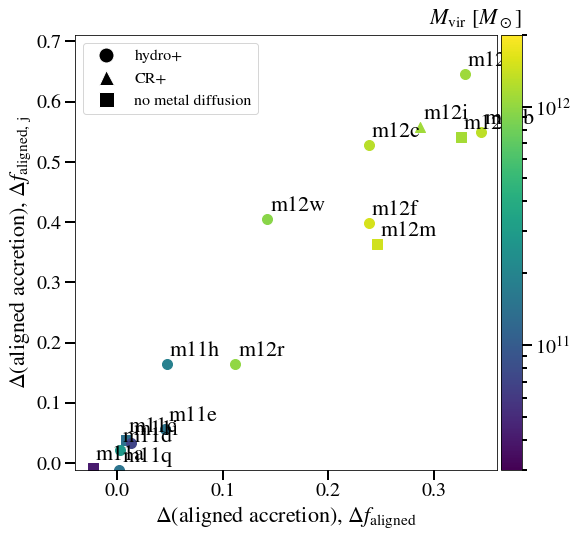

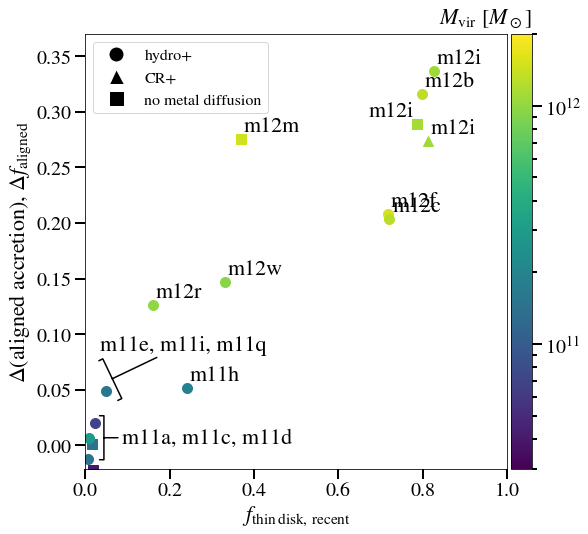

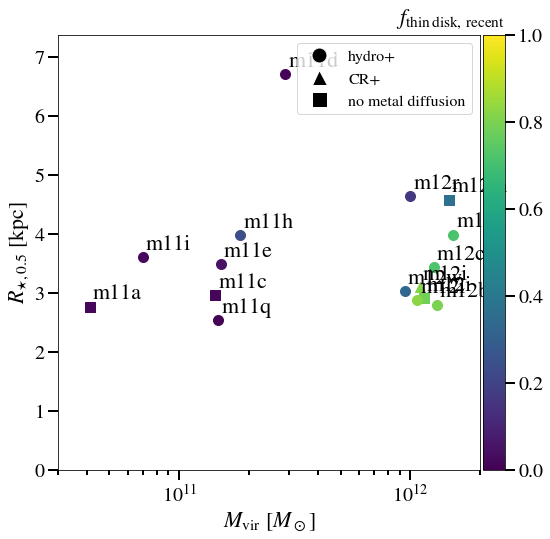

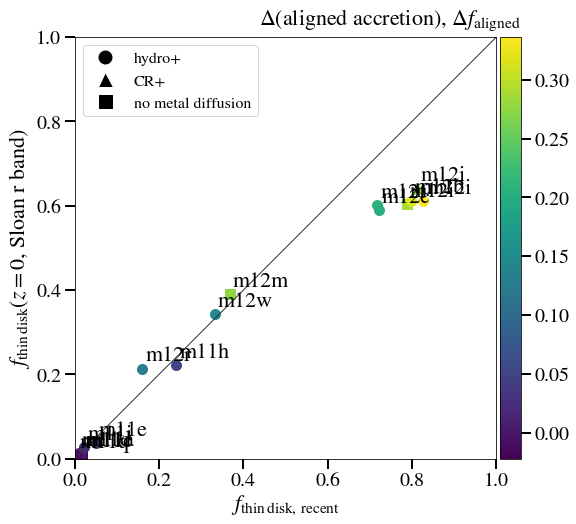

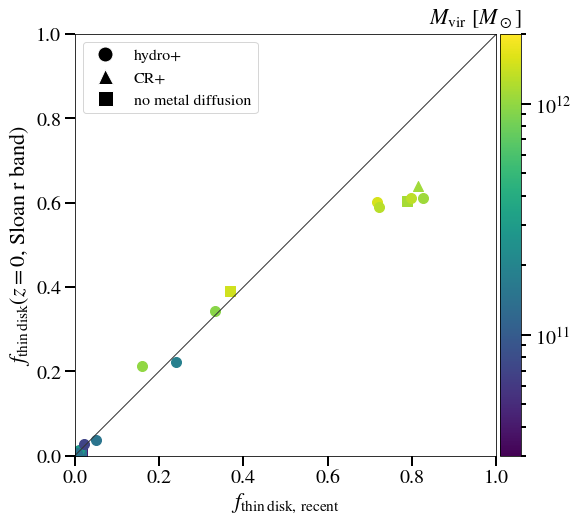

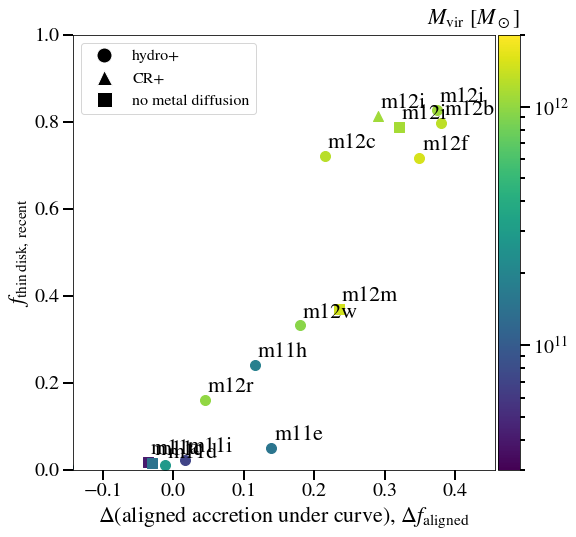

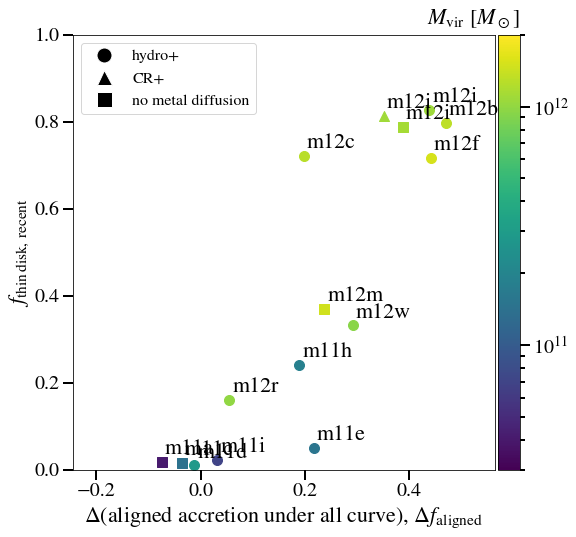

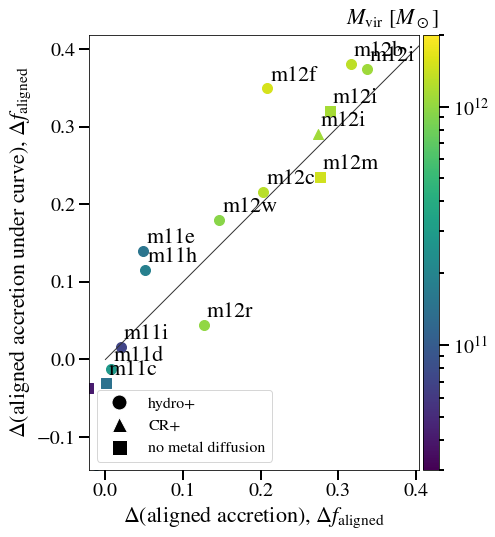

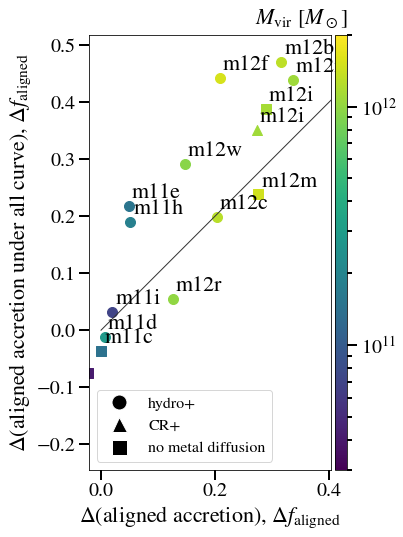

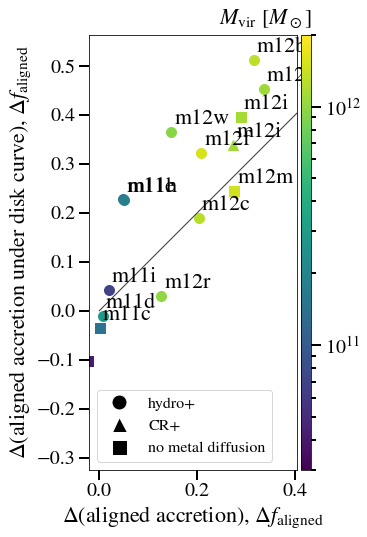

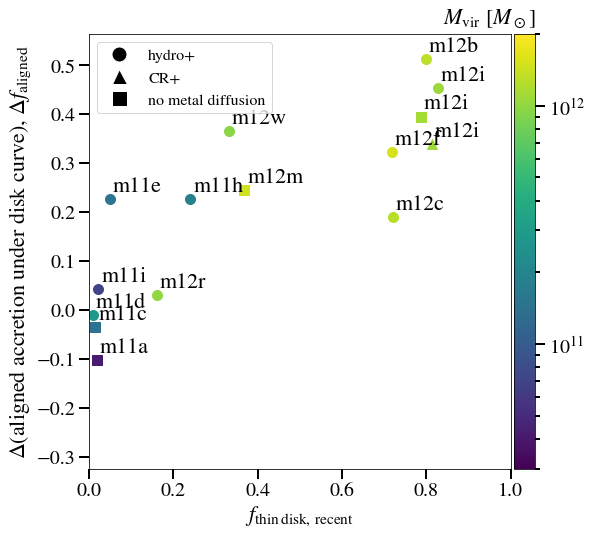

In [41]:
for i, (x_key, y_key, z_key) in enumerate( combinations ):
    
    xs = values[x_key]
    ys = values[y_key]
    zs = values[z_key]
    
    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale
        
    x_lims = get_lim( xs, x_log, x_key, 1.2, 0.95 )
    y_lims = get_lim( ys, y_log, y_key, 1.1, 0.95 )
    z_lims = get_lim( zs, z_log, z_key, )

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    for key in cp.variations :
        
        try:
            x = xs[key]
            y = ys[key]
            z = zs[key]
        except KeyError:
            continue
        
        if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
            continue
        elif not key in cp.variations:
            continue
        
        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
            
        s = ax.scatter(
            x,
            y,
            s = 100,
            color = c,
            marker = markers[physics]
        )

        if (x_key, y_key, z_key) not in combinations_no_annotate:
            # Annotate simulation names
            annot_args = {
                'textcoords': 'offset points',
                'fontsize': 22,
                'va': 'bottom',
                'ha': 'left',
                'xytext': ( 3, 3 ),
            }
            # Custom annotation arguments
            if ( x_key, y_key ) in custom_annot_args:
                if key in custom_annot_args[(x_key,y_key)]:
                    custom_args = custom_annot_args[(x_key,y_key)][key]
                    if custom_args is not None:
                        annot_args.update( custom_args )
                    else:
                        annot_args = None
            if annot_args is not None:
                ax.annotate(
                    text = sim_name,
                    xy = ( x, y ),
                    **annot_args
                )
            # Special cases
            if ( x_key, y_key ) == ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ):
                if key == 'm11e_md':
                    ax.annotate(
                        text = 'm11a, m11c, m11d\nm11e, m11i, m11q',
                        xy = ( x+0.05, y ),
                        xytext = ( 30, 5 ),
                        textcoords = 'offset points',
                        fontsize = 22,
                        va = 'center',
                        arrowprops = {
                            'arrowstyle': '-[',
                            'lw': 1.5,
                        },
                    )
            elif ( x_key, y_key ) == ( 'thin_disk_frac_recent', 'delta_disk_frac' ):
                if key == 'm11e_md':
                    ax.annotate(
                        text = 'm11e, m11i, m11q',
                        xy = ( x+0.01, y+0.01 ),
                        xytext = ( -10, 35 ),
                        textcoords = 'offset points',
                        fontsize = 22,
                        ha = 'left',
                        va = 'center',
                        arrowprops = {
                            'arrowstyle': '-[',
                            'lw': 1.5,
                        },
                    )
                elif key == 'm11d_md':
                    ax.annotate(
                        text = 'm11a, m11c, m11d',
                        xy = ( x+0.03, y ),
                        xytext = ( 20, 0 ),
                        textcoords = 'offset points',
                        fontsize = 22,
                        va = 'center',
                        arrowprops = {
                            'arrowstyle': '-[',
                            'lw': 1.5,
                        },
                    )
        
    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )
    
    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )
    
    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )
    
    if ( x_key in fractions and y_key in fractions ) or ( x_key[:15] == 'delta_disk_frac' and y_key[:15] == 'delta_disk_frac' ):
        ax.set_aspect( 'equal' )
        ax.plot(
            [ 0, 1 ],
            [ 0, 1 ],
            color = '.2',
            linewidth = 1,
        )
    
    # Legend
    legend_elements = [
        Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
        for _ in markers.keys()
    ]
    ax.legend(
        handles=legend_elements,
        prop = {'size': 16 },
    )
    
    # Colorbar
    if not z_log:
        norm_class = mpl.colors.Normalize
    else:
        norm_class = mpl.colors.LogNorm
    norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
    divider = make_axes_locatable( ax )
    cax = divider.append_axes( "right", pad=0.05, size='5%' )
    cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )
    
    # Colorbar label
    cax.annotate(
        text = labels[z_key],
        xy = (1,1),
        xytext = ( 0, 5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 22,
        ha = 'right',
        va = 'bottom',
    )
    
    if (x_key, y_key, z_key) in combinations_to_save:
        plotting.save_fig(
            out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
            save_file = 'thin_disk_v_thin_disk.pdf',
            fig = fig,
        )

## Multi-Panel

In [42]:
all_multipanel_combinations = [
    [
        ( 'mvir', 'delta_disk_frac', 'thin_disk_frac_recent', ),
        ( 'mstar', 'delta_disk_frac', 'thin_disk_frac_recent', ),
        ( 'tcool_tff', 'delta_disk_frac', 'thin_disk_frac_recent', ),
    ],
    [
        ( 'mvir', 'thin_disk_frac_recent', 'delta_disk_frac', ),
        ( 'mstar', 'thin_disk_frac_recent', 'delta_disk_frac', ),
        ( 'tcool_tff', 'thin_disk_frac_recent', 'delta_disk_frac', ),
#         ( 'thin_disk_frac_sloanr', 'thin_disk_frac_recent', 'delta_disk_frac', ),
    ],
    [
        ( 'mvir', 'thin_disk_frac_sloanr', 'delta_disk_frac', ),
        ( 'mstar', 'thin_disk_frac_sloanr', 'delta_disk_frac', ),
        ( 'tcool_tff', 'thin_disk_frac_sloanr', 'delta_disk_frac', ),
    ],
]
multipanel_to_save = 1

In [43]:
cmap = palettable.matplotlib.Plasma_20.mpl_colormap

<ipython-input-44-22a61fa1c85e>:193: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( new_ticklabels )


File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/aligned_fraction_vs_galaxy_props.pdf


<ipython-input-44-22a61fa1c85e>:193: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( new_ticklabels )


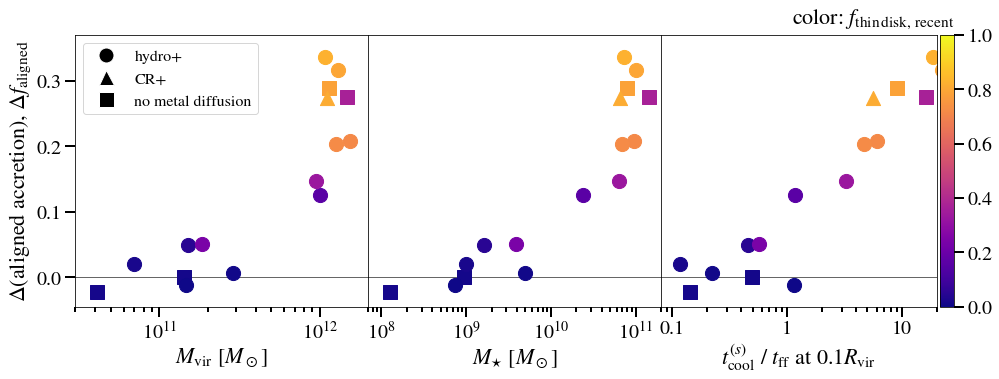

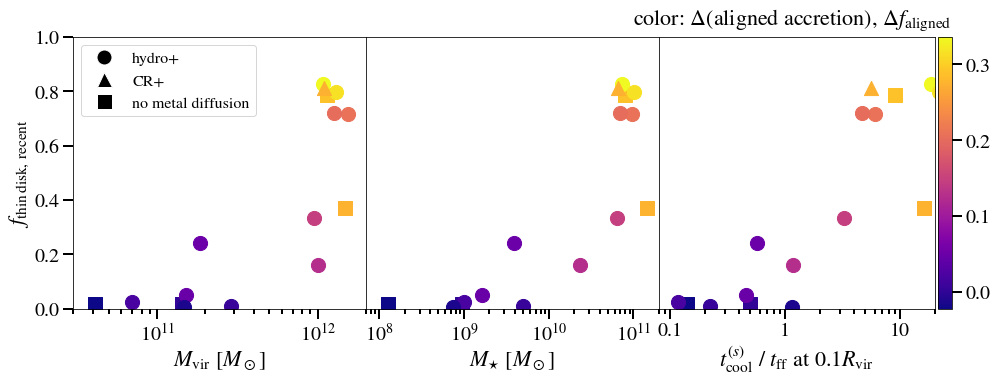

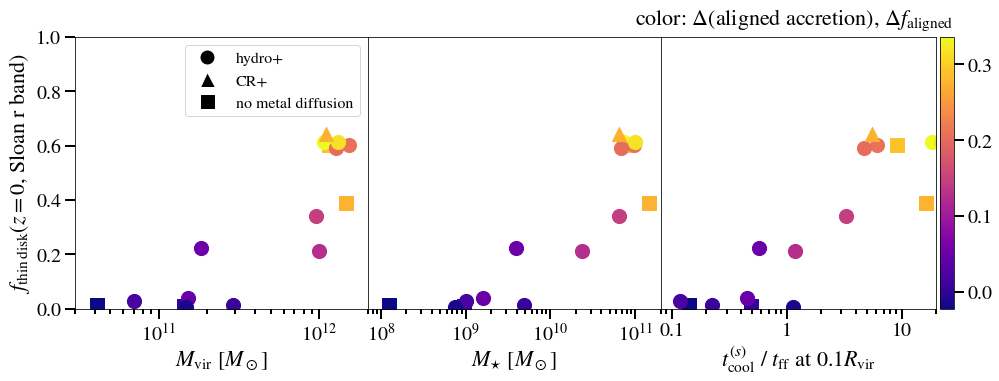

In [44]:
for m, multipanel_combinations in enumerate( all_multipanel_combinations ):

    n_cols = len( multipanel_combinations )

    5.27*n_cols
    sidelength = 5
    fig = plt.figure( figsize=(sidelength * ( n_cols - 1 ) + 1.15 * sidelength, sidelength), facecolor='w' )
    main_ax = plt.gca()

    gs = gridspec.GridSpec( 1, n_cols )
    gs.update( wspace=0.0001 )

    invalid = []
    for i, (x_key, y_key, z_key) in enumerate( multipanel_combinations ):

        panel_invalid = []

        ax = plt.subplot(gs[0,i])

        xs = values[x_key]
        ys = values[y_key]
        zs = values[z_key]

        x_log = x_key in logscale
        y_log = y_key in logscale
        z_log = z_key in logscale

        x_lims = get_lim( xs, x_log, x_key, 1.2, )
        y_lims = get_lim( ys, y_log, y_key, 1.1, 2 )
        z_lims = get_lim( zs, z_log, z_key, )

        for key in cp.variations :

            try:
                x = xs[key]
                y = ys[key]
                z = zs[key]
            except KeyError:
                panel_invalid.append( key )
                continue

            if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
                continue

            elif not key in cp.variations:
                continue

            if '_' in key:
                sim_name, physics = key.split( '_' )
            else:
                sim_name = key
                physics = ''

            if not z_log:
                c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
            else:
                c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
            c = cmap( c_value )

            s = ax.scatter(
                x,
                y,
                s = 200,
                color = c,
                marker = markers[physics]
            )

    #         # Annotate simulation names
    #         annot_args = {
    #             'textcoords': 'offset points',
    #             'fontsize': 22,
    #             'va': 'bottom',
    #             'ha': 'left',
    #             'xytext': ( 3, 3 ),
    #         }
    #         # Custom annotation arguments
    #         if ( x_key, y_key ) in custom_annot_args:
    #             if key in custom_annot_args[(x_key,y_key)]:
    #                 custom_args = custom_annot_args[(x_key,y_key)][key]
    #                 if custom_args is not None:
    #                     annot_args.update( custom_args )
    #                 else:
    #                     annot_args = None
    #         if annot_args is not None:
    #             ax.annotate(
    #                 s = sim_name,
    #                 xy = ( x, y ),
    #                 **annot_args
    #             )
    #         # Special cases
    #         if ( x_key, y_key ) == ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ):
    #             if key == 'm11e_md':
    #                 ax.annotate(
    #                     s = 'm11a, m11c, m11d\nm11e, m11i, m11q',
    #                     xy = ( x+0.05, y ),
    #                     xytext = ( 30, 5 ),
    #                     textcoords = 'offset points',
    #                     fontsize = 22,
    #                     va = 'center',
    #                     arrowprops = {
    #                         'arrowstyle': '-[',
    #                         'lw': 1.5,
    #                     },
    #                 )

        ax.set_xlabel( labels[x_key], fontsize=22 )
        if ax.is_first_col():
            ax.set_ylabel( labels[y_key], fontsize=22 )

        # Zero line
        if y_key == 'delta_disk_frac':
            ax.axhline(
                0,
                color = pm['background_linecolor'],
                linewidth = 1,
                zorder = -100,
            )

        if x_log:
            ax.set_xscale( 'log' )
        if y_log:
            ax.set_yscale( 'log' )

        ax.set_xlim( x_lims )
        ax.set_ylim( y_lims )

        if not ax.is_first_col():
            ax.tick_params( left=False, labelleft=False )

        if ax.is_first_col():
            # Legend
            legend_elements = [
                Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
                for _ in markers.keys()
            ]
            ax.legend(
                handles=legend_elements,
                prop = {'size': 16 },
            )

        if ax.is_last_col():
            # Colorbar
            if not z_log:
                norm_class = mpl.colors.Normalize
            else:
                norm_class = mpl.colors.LogNorm
            norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
            divider = make_axes_locatable( ax )
            cax = divider.append_axes( "right", pad=0.05, size='5%' )
            cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )

            # Colorbar label
            cax.annotate(
                text = 'color: '+ labels[z_key],
                xy = (1,1),
                xytext = ( 0, 5 ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                fontsize = 22,
                ha = 'right',
                va = 'bottom',
            )
            
        if x_key == 'mstar':
            ax.set_xticks( [ 1e8, 1e9, 1e10, 1e11 ])
            locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
            ax.xaxis.set_minor_locator(locmin)
            ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

        # Behavior for fractions/not fractions plot
        if x_key in fractions and y_key in fractions:
            ax.set_aspect( 'equal' )
            ax.plot(
                [ 0, 1 ],
                [ 0, 1 ],
                color = '.2',
                linewidth = 1,
                zorder = -100,
            )
        else:
            tick_values = ax.get_xticks()
            new_ticklabels = []
            modified = False
            for i, tick_label in enumerate( ax.get_xticklabels() ):
                replace_values = [ 0.01, 0.1, 1., 10., 100. ]
                replace_strs = [ '0.01', '0.1', '1', '10', '100' ]
                for j, replace_val in enumerate( replace_values ):
                    if np.isclose( tick_values[i], replace_val ):
                        tick_label.set_text( replace_strs[j] )
                        modified = True
                new_ticklabels.append( tick_label )
            if modified:
                ax.set_xticklabels( new_ticklabels )

        invalid.append( panel_invalid )

    if m == multipanel_to_save:
        plotting.save_fig(
            out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
            save_file = 'aligned_fraction_vs_galaxy_props.pdf',
            fig = fig,
        )

In [45]:
invalid

[[], [], []]

## Connected Before-After

In [46]:
multi_values = {
    'sigma_cosphi': sigma_cosphi,
    'med_cosphi': med_cosphi,
    'abs_med_cosphi': abs_med_cosphi,
    'pdfcosphi_0': data['cosphi']['pdf(cos theta=0)'],
    'disk_frac': disk_frac,
}

In [47]:
rd_bu_cmap = palettable.scientific.diverging.Berlin_3_r.mpl_colors

In [48]:
annotate = False

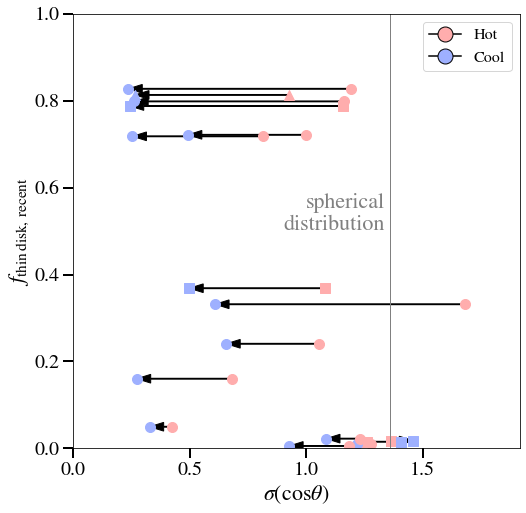

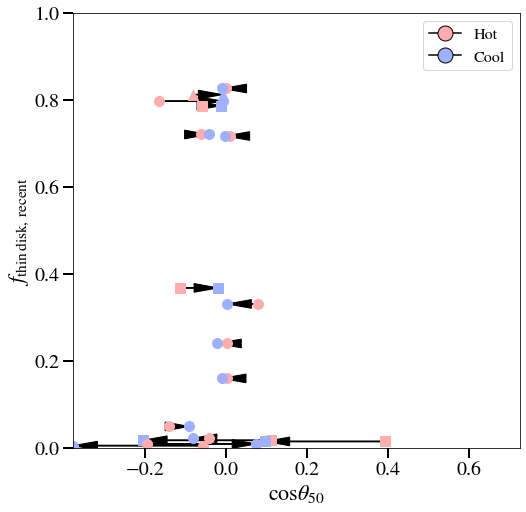

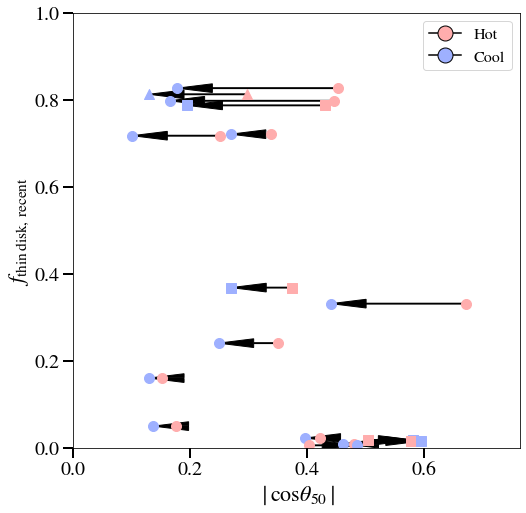

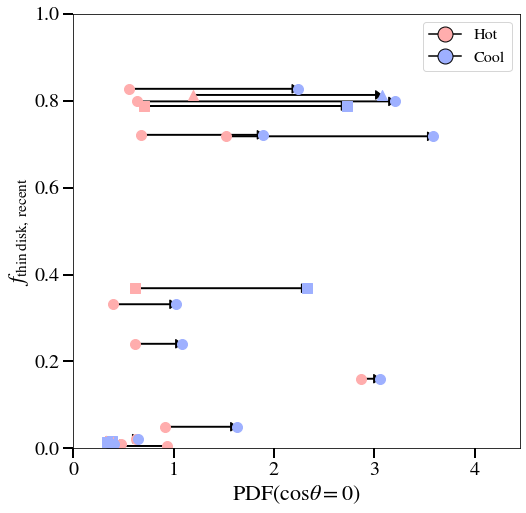

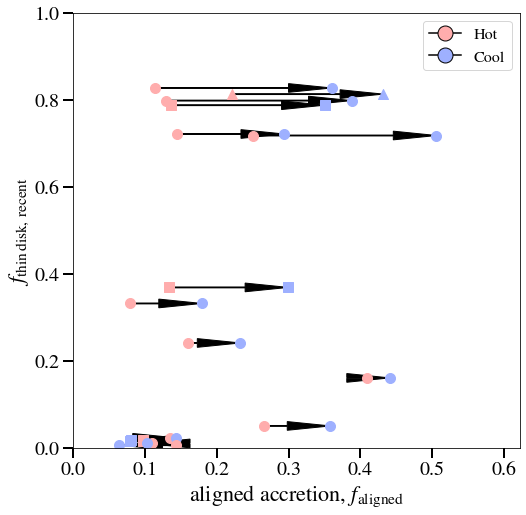

In [49]:
for x_key in multi_values.keys():

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    y_key = 'thin_disk_frac_recent'

    xs = multi_values[x_key]
    xs_pre = xs.inner_item( 0 )
    xs_post = xs.inner_item( -1 )
    ys = values[y_key]

    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale

    x_lims = get_lim( xs, x_log, x_key, 1.1 )
    y_lims = get_lim( ys, y_log, y_key, 1.1 )

    for key in cp.variations:

        try:
            x_pre = xs_pre[key]
            y = ys[key]
        except KeyError:
            continue

        if np.isnan( x_pre ):
            continue

        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        # Pre
        s = ax.scatter(
            x_pre,
            y,
            s = 100,
            color = rd_bu_cmap[0],
            marker = markers[physics]
        )
        s = ax.scatter(
            xs_post[key],
            y,
            s = 100,
            color = rd_bu_cmap[-1],
            marker = markers[physics]
        )

        if annotate:
            ax.annotate(
                text = sim_name,
                xy = ( x_pre, y ),
                xytext = ( 5, 5 ),
                textcoords = 'offset points',
                fontsize = 22,
                ha = 'left',
                va = 'bottom',
            )

        ax.arrow(
            x_pre, y,
            xs_post[key] - x_pre, 0,
    #         linewidth = 1.5,
            color = 'k',
            zorder = -100,
            width = 0.002,
            head_length = 0.06,
            head_width = 0.02,
            length_includes_head = True,
        )

    if x_key == 'sigma_cosphi':
        # Reference lines
        sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
        ax.axvline(
            sigma_cosphi_sphere,
            color = '.5',
            linestyle = '-',
            linewidth = 1,
        )
        ax.annotate(
            text = 'spherical\ndistribution',
            xy = ( sigma_cosphi_sphere, 0.6 ),
            xycoords = 'data',
            xytext = ( -5, -5 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 22,
            color = '.5',
        )

    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )

    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )

    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )

    # Legend
    legend_labels = [ 'Hot', 'Cool' ]
    legend_elements = [
    Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_cmap[_], markersize=15)
    for _ in [ 0, -1 ]
    ]
    ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
    )

## Combined

In [50]:
multi_values = {
    'smooth_disk_frac': smooth_disk_frac,
    'smooth_jdisk_frac': smooth_jdisk_frac,
}

In [51]:
t_t1e5_centers = list( data['cosphi']['t_t1e5_centers'].values() )[0]

In [52]:
rd_bu_colors = palettable.scientific.diverging.Berlin_3_r.mpl_colors
rd_bu_colors_base = palettable.scientific.diverging.Roma_20
rd_bu_colors = rd_bu_colors_base.mpl_colors
rd_bu_cmap = rd_bu_colors_base.mpl_colormap

In [53]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

In [54]:
annotate = False

In [55]:
sims_subset = []

In [56]:
norm_instance = matplotlib.colors.Normalize( vmin=-pm['aligned_fraction_half_dt']/1000., vmax=pm['aligned_fraction_half_dt']/1000. )

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/aligned_fraction.pdf


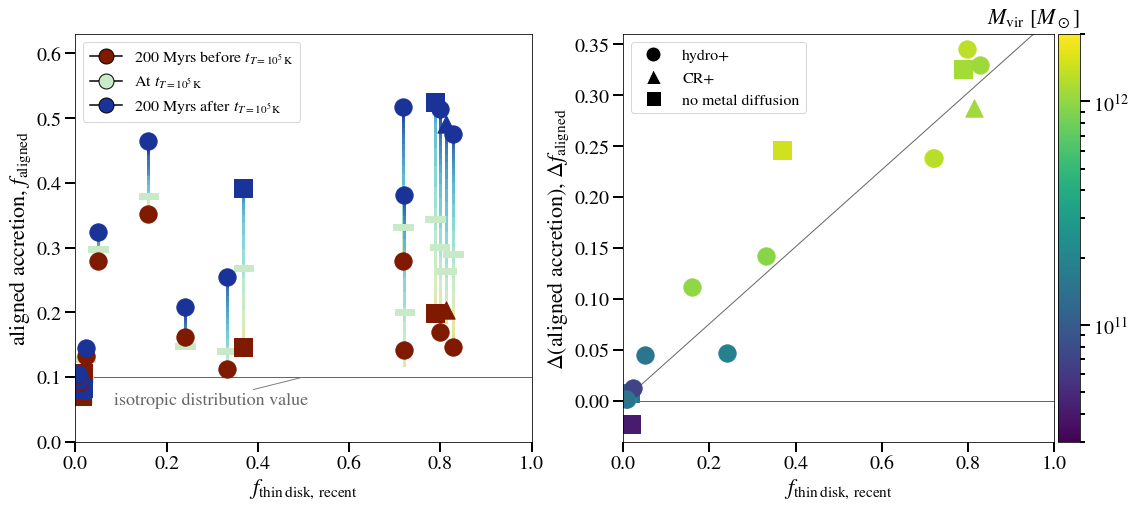

In [57]:
n_cols = 2
n_rows = 1
scale = 1.5

fig = plt.figure( figsize=(6*n_cols*scale,5*scale), facecolor='w' )
main_ax = plt.gca()

gs = gridspec.GridSpec( 1, n_cols )
#     gs.update( wspace=0.0001 )

x_key = 'thin_disk_frac_recent'
z_key = 'mvir'
y_key = 'smooth_disk_frac'

xs = values[x_key]
zs = values[z_key]
ys = values[y_key]
y_multis = multi_values[y_key]
ys_pre = ys.inner_item( before_ind )
ys_post = ys.inner_item( after_ind )
ys_delta = ys_post - ys_pre

x_log = x_key in logscale
y_log = y_key in logscale
z_log = z_key in logscale

x_lims = get_lim( xs, x_log, x_key, 1.1 )
y_lims = get_lim( ys, y_log, y_key, 1.1 )

####################################################
# Left panel
####################################################

ax = plt.subplot( gs[0,0] )

for key in cp.variations:
    
    if key not in sims_subset and len( sims_subset ) > 0:
        continue

    try:
        y_pre = ys_pre[key]
        x = xs[key]
    except KeyError:
        continue

    if np.isnan( y_pre ):
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    # Pre
    s = ax.scatter(
        x,
        y_pre,
        s = 300,
        color = rd_bu_colors[0],
        marker = markers[physics]
    )
    # Post
    s = ax.scatter(
        x,
        ys_post[key],
        s = 300,
        color = rd_bu_colors[-1],
        marker = markers[physics]
    )
    # Change along the way
    y_multi_vals = y_multis[key]
    for j, val in enumerate( y_multi_vals ):
        
        if np.abs( t_t1e5_centers[j] ) > pm['aligned_fraction_half_dt'] / 1000.:
            continue
        
        valtime = t_t1e5_centers[j] + data['t1e5_offset'][key] / 1000.
        valcolor = rd_bu_cmap( norm_instance( valtime ) )
        
#         # Ticks
#         tick_length = 0.015
#         linewidth = 5
#         if np.isclose( t_t1e5_centers[j], 0.0 ):
#             linewidth = 7
#             tick_length *= 2
#             ax.plot(
#                 [ x - tick_length / 2, x + tick_length / 2],
#                 [ val, ] * 2,
#                 linewidth = linewidth,
#                 color = rd_bu_colors[j],
#                 zorder = -10,
#             )
            
            # Markers
#             ax.scatter(
#                 [ x, ] ,
#                 [ val, ] * 2,
#                 color = rd_bu_colors[j],
#                 s = 300,
#                 marker = markers[physics]
#             )

        # Line itself
        if j != 0:
            start_point = 0.5 * ( val + y_multi_vals[j-1] )
        else:
            start_point = val
        if j != len( y_multi_vals ) - 1:
            end_point = 0.5 * ( y_multi_vals[j+1] + val )
        else:
            end_point = val
        ax.plot(
            [ x, ] * 2,
            [ start_point, end_point ],
            linewidth = 3,
            color = valcolor,
            zorder = -20,
        )
#     s = ax.scatter(
#         [ x, ] * len( y_multi_vals ),
#         y_multi_vals,
#         s = 300,
#         color = rd_bu_colors,
#         marker = markers[physics],
#     )

    # Mark center
    j_center = np.argmin(np.abs(t_t1e5_centers))
    y_prev = y_multi_vals[j_center]
    linewidth = 7
    tick_length = 0.03
    valinterp = scipy.interpolate.interp1d( t_t1e5_centers[j_center:j_center+4], y_multi_vals[j_center:j_center+4] )
    val = valinterp( data['t1e5_offset'][key] / 1000. )
    ax.plot(
        [ x - tick_length / 2, x + tick_length / 2],
        [ val, ] * 2,
        linewidth = linewidth,
        color = rd_bu_cmap( norm_instance( 0. ) ),
        zorder = -10,
    )

    if annotate:
        ax.annotate(
            text = sim_name,
            xy = ( x, y_pre ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
    ax.plot(
        [ x, x ],
        [ y_pre, ys_post[key] ],
        linewidth = 1,
        color = 'k',
        zorder = -100,
    )

if y_key == 'sigma_cosphi':
    # Reference lines
    sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
    ax.axvline(
        sigma_cosphi_sphere,
        color = pm['background_linecolor'],
        linestyle = '-',
        linewidth = 1,
    )
    ax.annotate(
        text = 'spherical\ndistribution',
        xy = ( sigma_cosphi_sphere, 0.6 ),
        xycoords = 'data',
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
        fontsize = 22,
        color = '.5',
    )
elif ( y_key == 'disk_frac' ) or ( y_key == 'smooth_disk_frac' ):
    ax.axhline(
        pm['disk_costheta'],
        color = pm['background_linecolor'],
        linewidth = 1,
        zorder = -100,
    )
    ax.annotate(
        text = 'isotropic distribution value',
        xy = ( 0.5, pm['disk_costheta'] ),
        xycoords = 'data',
        xytext = ( 5, -15 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
        fontsize = 18,
        color = pm['background_linecolor'],
        arrowprops = { 'arrowstyle': '-', 'color': '.5', },
    )
    
#     # Typical value for thin disk stars
#     ax.axhline(
#         aligned_frac['m12i_md'],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#         zorder = -100,
#     )
#     ax.annotate(
#         text = 'value for thin disk stars',
#         xy = ( 0.5, aligned_frac['m12i_md'] ),
#         xycoords = 'data',
#         xytext = ( 5, -15 ),
#         textcoords = 'offset points',
#         ha = 'right',
#         va = 'top',
#         fontsize = 18,
#         color = pm['background_linecolor'],
#         arrowprops = { 'arrowstyle': '-', 'color': '.5', },
#     )


ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

# ax.annotate(
#     text = 'Aligned mass fraction',
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 20,
#     ha = 'left',
#     va = 'bottom',
# )

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( 0, 0.63 )

# Legend
rd_bu_colors_legend = palettable.scientific.diverging.Roma_3.mpl_colors
# legend_labels = [ r'$t = t_{T = 10^5\,{\rm K}} - 150$ Myr', r'$t = t_{T = 10^5\,{\rm K}}$', r'$t = t_{T = 10^5\,{\rm K}} + 150$ Myr' ]
legend_labels = [
    '{} Myrs before '.format( pm['aligned_fraction_half_dt'] ) + r'$t_{T = 10^5\,{\rm K}}$',
    r'At $t_{T = 10^5\,{\rm K}}$',
    '{} Myrs after '.format( pm['aligned_fraction_half_dt'] ) + r'$t_{T = 10^5\,{\rm K}}$'
]
legend_elements = [
Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_colors_legend[_], markersize=15)
for _ in [ 0, 1, 2 ]
]
l = ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
    loc = 'upper left',
)
l.set_alpha( 1. )

####################################################
# Right panel
####################################################

y_key = 'delta_' + y_key

x_lims = get_lim( xs, x_log, x_key, 1.2, )
y_lims = get_lim( ys_delta, y_log, y_key, 1.1, 2 )
z_lims = get_lim( zs, z_log, z_key, )

ax = plt.subplot(gs[0,1])

for key in cp.variations :

    try:
        x = xs[key]
        y = ys_delta[key]
        z = zs[key]
    except KeyError:
        continue

    if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
        continue
    elif not key in cp.variations:
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    if not z_log:
        c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
    else:
        c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
    c = cmap( c_value )

    s = ax.scatter(
        x,
        y,
        s = 300,
        color = c,
        marker = markers[physics]
    )
    
# Zero line
if y_key in [ 'delta_disk_frac', 'delta_smooth_disk_frac' ]:
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 1,
        zorder = -100,
    )

ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

# ax.annotate(
#     text = 'Change in aligned mass fraction',
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 20,
#     ha = 'left',
#     va = 'bottom',
# )

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

if x_key in fractions and y_key in fractions:
    ax.set_aspect( 'equal' )
    ax.plot(
        [ 0, 1 ],
        [ 0, 1 ],
        color = pm['lighter_background_linecolor'],
        linewidth = 1,
    )

# Legend
legend_elements = [
    Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
    for _ in markers.keys()
]
ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
)

# Proportional Line
thin_disk_fracs_for_thin_disks = []
delta_disk_frac_for_thin_disks = []
for key, item in values['thin_disk_frac_recent'].items():
    if item > 0.5:
        thin_disk_fracs_for_thin_disks.append( item )
        delta_disk_frac_for_thin_disks.append( values['delta_smooth_disk_frac'][key] )
average_thin_disk_frac_for_thin_disks = np.mean( thin_disk_fracs_for_thin_disks )
average_delta_disk_frac_for_thin_disks = np.mean( delta_disk_frac_for_thin_disks )
ax.plot(
    [ 0, 1 ],
    [ 0, average_delta_disk_frac_for_thin_disks / average_thin_disk_frac_for_thin_disks ],
    color = pm['background_linecolor'],
    linewidth = 1,
    zorder = -100,
)

# Colorbar
if not z_log:
    norm_class = mpl.colors.Normalize
else:
    norm_class = mpl.colors.LogNorm
norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
divider = make_axes_locatable( ax )
cax = divider.append_axes( "right", pad=0.05, size='5%' )
cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )

# Colorbar label
cax.annotate(
    text = labels[z_key],
    xy = (1,1),
    xytext = ( 0, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'bottom',
)

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
    save_file = 'aligned_fraction.pdf',
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/aligned_fraction_ang_momentum.pdf


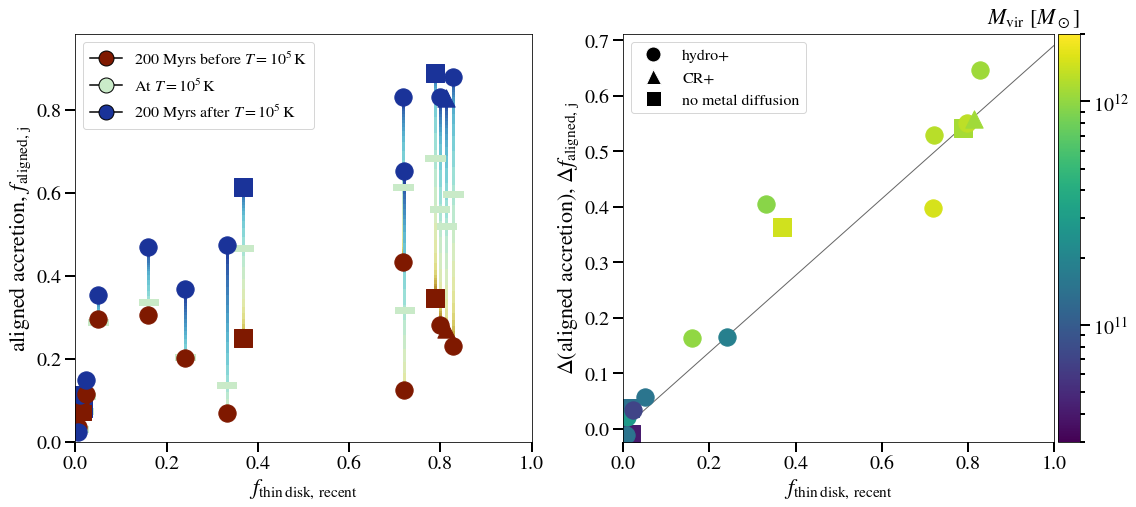

In [58]:
n_cols = 2
n_rows = 1
scale = 1.5

fig = plt.figure( figsize=(6*n_cols*scale,5*scale), facecolor='w' )
main_ax = plt.gca()

gs = gridspec.GridSpec( 1, n_cols )
#     gs.update( wspace=0.0001 )

x_key = 'thin_disk_frac_recent'
z_key = 'mvir'
y_key = 'smooth_jdisk_frac'

xs = values[x_key]
zs = values[z_key]
ys = values[y_key]
y_multis = multi_values[y_key]
ys_pre = ys.inner_item( before_ind )
ys_post = ys.inner_item( after_ind )
ys_delta = ys_post - ys_pre

x_log = x_key in logscale
y_log = y_key in logscale
z_log = z_key in logscale

x_lims = get_lim( xs, x_log, x_key, 1.1 )
y_lims = get_lim( ys, y_log, y_key, 1.1 )

####################################################
# Left panel
####################################################

ax = plt.subplot( gs[0,0] )

for key in cp.variations:
    
    if key not in sims_subset and len( sims_subset ) > 0:
        continue

    try:
        y_pre = ys_pre[key]
        x = xs[key]
    except KeyError:
        continue

    if np.isnan( y_pre ):
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    # Pre
    s = ax.scatter(
        x,
        y_pre,
        s = 300,
        color = rd_bu_colors[0],
        marker = markers[physics]
    )
    # Post
    s = ax.scatter(
        x,
        ys_post[key],
        s = 300,
        color = rd_bu_colors[-1],
        marker = markers[physics]
    )
    # Change along the way
    y_multi_vals = y_multis[key]
    for j, val in enumerate( y_multi_vals ):
        
        if np.abs( t_t1e5_centers[j] ) > pm['aligned_fraction_half_dt'] / 1000.:
            continue
        
        valtime = t_t1e5_centers[j] + data['t1e5_offset'][key] / 1000.
        valcolor = rd_bu_cmap( norm_instance( valtime ) )
        
#         # Ticks
#         tick_length = 0.015
#         linewidth = 5
#         if np.isclose( t_t1e5_centers[j], 0.0 ):
#             linewidth = 7
#             tick_length *= 2
#             ax.plot(
#                 [ x - tick_length / 2, x + tick_length / 2],
#                 [ val, ] * 2,
#                 linewidth = linewidth,
#                 color = rd_bu_colors[j],
#                 zorder = -10,
#             )
            
            # Markers
#             ax.scatter(
#                 [ x, ] ,
#                 [ val, ] * 2,
#                 color = rd_bu_colors[j],
#                 s = 300,
#                 marker = markers[physics]
#             )

        # Line itself
        if j != 0:
            start_point = 0.5 * ( val + y_multi_vals[j-1] )
        else:
            start_point = val
        if j != len( y_multi_vals ) - 1:
            end_point = 0.5 * ( y_multi_vals[j+1] + val )
        else:
            end_point = val
        ax.plot(
            [ x, ] * 2,
            [ start_point, end_point ],
            linewidth = 3,
            color = valcolor,
            zorder = -20,
        )
#     s = ax.scatter(
#         [ x, ] * len( y_multi_vals ),
#         y_multi_vals,
#         s = 300,
#         color = rd_bu_colors,
#         marker = markers[physics],
#     )

    # Mark center
    j_center = np.argmin(np.abs(t_t1e5_centers))
    y_prev = y_multi_vals[j_center]
    linewidth = 7
    tick_length = 0.03
    valinterp = scipy.interpolate.interp1d( t_t1e5_centers[j_center:j_center+4], y_multi_vals[j_center:j_center+4] )
    val = valinterp( data['t1e5_offset'][key] / 1000. )
    ax.plot(
        [ x - tick_length / 2, x + tick_length / 2],
        [ val, ] * 2,
        linewidth = linewidth,
        color = rd_bu_cmap( norm_instance( 0. ) ),
        zorder = -10,
    )

    if annotate:
        ax.annotate(
            text = sim_name,
            xy = ( x, y_pre ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
    ax.plot(
        [ x, x ],
        [ y_pre, ys_post[key] ],
        linewidth = 1,
        color = 'k',
        zorder = -100,
    )

if y_key == 'sigma_cosphi':
    # Reference lines
    sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
    ax.axvline(
        sigma_cosphi_sphere,
        color = pm['background_linecolor'],
        linestyle = '-',
        linewidth = 1,
    )
    ax.annotate(
        text = 'spherical\ndistribution',
        xy = ( sigma_cosphi_sphere, 0.6 ),
        xycoords = 'data',
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
        fontsize = 22,
        color = '.5',
    )
elif y_key == 'disk_frac':
    ax.axhline(
        pm['disk_costheta'],
        color = pm['background_linecolor'],
        linewidth = 1,
        zorder = -100,
    )
    ax.annotate(
        text = 'isotropic distribution value',
        xy = ( 0.5, pm['disk_costheta'] ),
        xycoords = 'data',
        xytext = ( 5, -15 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
        fontsize = 18,
        color = pm['background_linecolor'],
        arrowprops = { 'arrowstyle': '-', 'color': '.5', },
    )
    
#     # Typical value for thin disk stars
#     ax.axhline(
#         aligned_frac['m12i_md'],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#         zorder = -100,
#     )
#     ax.annotate(
#         text = 'value for thin disk stars',
#         xy = ( 0.5, aligned_frac['m12i_md'] ),
#         xycoords = 'data',
#         xytext = ( 5, -15 ),
#         textcoords = 'offset points',
#         ha = 'right',
#         va = 'top',
#         fontsize = 18,
#         color = pm['background_linecolor'],
#         arrowprops = { 'arrowstyle': '-', 'color': '.5', },
#     )


ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

# ax.annotate(
#     text = 'Aligned mass fraction',
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 20,
#     ha = 'left',
#     va = 'bottom',
# )

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

# Legend
rd_bu_colors_legend = palettable.scientific.diverging.Roma_3.mpl_colors
# legend_labels = [ r'$t = t_{T = 10^5\,{\rm K}} - 150$ Myr', r'$t = t_{T = 10^5\,{\rm K}}$', r'$t = t_{T = 10^5\,{\rm K}} + 150$ Myr' ]
legend_labels = [
    '{} Myrs before '.format( pm['aligned_fraction_half_dt'] ) + r'$T = 10^5\,{\rm K}$',
    r'At $T = 10^5\,{\rm K}$',
    '{} Myrs after '.format( pm['aligned_fraction_half_dt'] ) + r'$T = 10^5\,{\rm K}$'
]
legend_elements = [
Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_colors_legend[_], markersize=15)
for _ in [ 0, 1, 2 ]
]
ax.legend(
handles=legend_elements,
prop = {'size': 16 },
)

####################################################
# Right panel
####################################################

y_key = 'delta_' + y_key

x_lims = get_lim( xs, x_log, x_key, 1.2, )
y_lims = get_lim( ys_delta, y_log, y_key, 1.1, 2 )
z_lims = get_lim( zs, z_log, z_key, )

ax = plt.subplot(gs[0,1])

for key in cp.variations :

    try:
        x = xs[key]
        y = ys_delta[key]
        z = zs[key]
    except KeyError:
        continue

    if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
        continue
    elif not key in cp.variations:
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    if not z_log:
        c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
    else:
        c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
    c = cmap( c_value )

    s = ax.scatter(
        x,
        y,
        s = 300,
        color = c,
        marker = markers[physics]
    )
    
# Zero line
if y_key == 'delta_disk_frac':
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 1,
        zorder = -100,
    )

ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

# ax.annotate(
#     text = 'Change in aligned mass fraction',
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 20,
#     ha = 'left',
#     va = 'bottom',
# )

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

if x_key in fractions and y_key in fractions:
    ax.set_aspect( 'equal' )
    ax.plot(
        [ 0, 1 ],
        [ 0, 1 ],
        color = pm['lighter_background_linecolor'],
        linewidth = 1,
    )

# Legend
legend_elements = [
    Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
    for _ in markers.keys()
]
ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
)

# Proportional Line
thin_disk_fracs_for_thin_disks = []
delta_disk_frac_for_thin_disks = []
for key, item in values['thin_disk_frac_recent'].items():
    if item > 0.5:
        thin_disk_fracs_for_thin_disks.append( item )
        delta_disk_frac_for_thin_disks.append( values['delta_smooth_jdisk_frac'][key] )
average_thin_disk_frac_for_thin_disks = np.mean( thin_disk_fracs_for_thin_disks )
average_delta_disk_frac_for_thin_disks = np.mean( delta_disk_frac_for_thin_disks )
ax.plot(
    [ 0, 1 ],
    [ 0, average_delta_disk_frac_for_thin_disks / average_thin_disk_frac_for_thin_disks ],
    color = pm['background_linecolor'],
    linewidth = 1,
    zorder = -100,
)

# Colorbar
if not z_log:
    norm_class = mpl.colors.Normalize
else:
    norm_class = mpl.colors.LogNorm
norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
divider = make_axes_locatable( ax )
cax = divider.append_axes( "right", pad=0.05, size='5%' )
cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )

# Colorbar label
cax.annotate(
    text = labels[z_key],
    xy = (1,1),
    xytext = ( 0, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'bottom',
)

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
    save_file = 'aligned_fraction_ang_momentum.pdf',
    fig = fig,
)

# Display Parameters

In [59]:
sort_inds = np.argsort( data['thin_disk_fraction_recent'].array() )
sorted_keys = data['thin_disk_fraction_recent'].keys_array()[sort_inds[::-1]]

In [60]:
data['disk_radius']['recent_thin_disk_stars']

Dict, {
'm11d_md' : 3.409922495663345,
}

In [61]:
def get_table_str( key ):
    
    if '_' in key:
        string, physics = key.split( '_' )
    else:
        string, physics = key, ''
    
    string += '  '
    printed_strs = [
        '{:.2g}'.format( data['thin_disk_fraction_recent'][key] ),
        '{:.2g}'.format( data['v_rot']['T<1.5e4 gas'][key] / data['sigma_r']['T<1.5e4 gas'][key] ),
        '$' + py2tex.to_tex_scientific_notation( mvir[key], 2 ) + '$',
        '$' + py2tex.to_tex_scientific_notation( mstar[key], 2 ) + '$',
        '{:.3g}'.format( rvir[key], 2 ),
        '{:.2g}'.format( delta_disk_frac[key] ),
        {
            'md': 'hydro+',
            'cr': 'CR+',
            '': 'no MD',
        }[physics],
        '?'
    ]
    
    for printed in printed_strs:
        string += '&  {}  '.format( printed )
        
    string += '  \\\\'
    
    return string

In [62]:
for key in sorted_keys:
    
    if key not in cp.variations:
        continue
        
    # Skip variants for later
    if key == 'm12i_cr' or key == 'm12i':
        continue
    
    string = get_table_str( key )
        
    print( string )

m12i  &  0.83  &  6  &  $1.1\times10^{12}$  &  $7.3\times10^{10}$  &  268  &  0.34  &  hydro+  &  ?    \\
m12b  &  0.8  &  5.7  &  $1.3\times10^{12}$  &  $1.0\times10^{11}$  &  286  &  0.32  &  hydro+  &  ?    \\
m12c  &  0.72  &  4.7  &  $1.3\times10^{12}$  &  $6.8\times10^{10}$  &  283  &  0.2  &  hydro+  &  ?    \\
m12f  &  0.72  &  5.2  &  $1.5\times10^{12}$  &  $9.7\times10^{10}$  &  302  &  0.21  &  hydro+  &  ?    \\
m12m  &  0.37  &  5.5  &  $1.5\times10^{12}$  &  $1.4\times10^{11}$  &  298  &  0.28  &  no MD  &  ?    \\
m12w  &  0.33  &  2  &  $9.5\times10^{11}$  &  $6.5\times10^{10}$  &  253  &  0.15  &  hydro+  &  ?    \\
m11h  &  0.24  &  0.89  &  $1.8\times10^{11}$  &  $3.9\times10^{9}$  &  146  &  0.051  &  hydro+  &  ?    \\
m12r  &  0.16  &  2.4  &  $1.0\times10^{12}$  &  $2.4\times10^{10}$  &  257  &  0.13  &  hydro+  &  ?    \\
m11e  &  0.05  &  0.53  &  $1.5\times10^{11}$  &  $1.6\times10^{9}$  &  136  &  0.049  &  hydro+  &  ?    \\
m11i  &  0.023  &  1.3  &  $7.0\t

In [63]:
for key in [ 'm12i_cr', 'm12i' ]:
    
    string = get_table_str( key )
        
    print( string )

m12i  &  0.81  &  7.6  &  $1.1\times10^{12}$  &  $6.5\times10^{10}$  &  270  &  0.27  &  CR+  &  ?    \\
m12i  &  0.79  &  5.6  &  $1.1\times10^{12}$  &  $8.0\times10^{10}$  &  274  &  0.29  &  no MD  &  ?    \\
